In [1]:
 import numpy as np
 import scipy as sci
 import matplotlib.pyplot as plt
 import pandas as pd
 import seaborn as sns
 import tensorflow as tf

In [2]:
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
def f(X):
    return X + 0.3*(tf.math.sin(2*pi*X) + tf.sin(4*pi*X))

In [97]:
numSamples = 50
# Define the hyperparameters
input_dim = 1
hidden_dim = 30
output_dim = 1
learning_rate = 0.001


pi    = np.pi
Xplot = tf.cast(tf.linspace(0, 3, 500), dtype='float32')
X     = tf.random.uniform(minval = 0, maxval = 3, shape=[numSamples], dtype='float32')
Y     = f(X);
Yplot = f(Xplot)
noise = tf.random.normal(Y.shape, mean=0, stddev = 0.2, dtype=Y.dtype);
Y     = Y+noise


x_train = tf.reshape(X, (numSamples, input_dim))
y_train = tf.reshape(Y, (numSamples, output_dim))

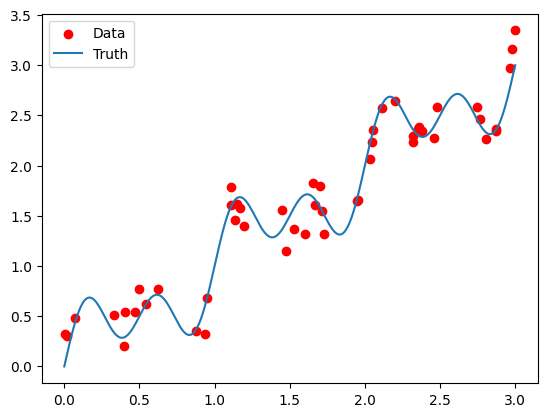

In [98]:
plt.scatter(X,Y,c='r',label='Data')
plt.plot(Xplot,Yplot, label = 'Truth')
plt.legend()

In [170]:
# Define the architecture of the neural network
class FeedForwardNN(tf.keras.Model):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(FeedForwardNN, self).__init__()
        self.layer1 = tf.keras.layers.Dense(hidden_dim, activation='tanh', input_dim=input_dim)
        self.layer2 = tf.keras.layers.Dense(hidden_dim, activation='tanh')
        self.layer3 = tf.keras.layers.Dense(hidden_dim, activation='tanh')
        self.output_layer = tf.keras.layers.Dense(output_dim, activation=None)
        self.concat_layer = tf.keras.layers.Concatenate()
        self.confidence_layer = tf.keras.layers.Dense(1, activation=None)

    def call(self, inputs):
        x      = self.layer1(inputs)
        x      = self.layer2(x)
        x      = self.layer3(x)

        output = self.output_layer(x)
        x      = self.concat_layer([x,output])
        sigma  = self.confidence_layer(x)
        return  tf.stack([output,sigma])
    
    
# Define the architecture of the neural network
class BDeepONet(tf.keras.Model):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(BDeepONet, self).__init__()
        self.layer1 = tf.keras.layers.Dense(hidden_dim, activation='tanh', input_dim=input_dim)
        self.layer2 = tf.keras.layers.Dense(hidden_dim, activation='tanh')
        self.layer3 = tf.keras.layers.Dense(hidden_dim, activation='tanh')
        
        self.layer4 = tf.keras.layers.Dense(hidden_dim, activation='tanh', input_dim=input_dim)
        self.layer5 = tf.keras.layers.Dense(hidden_dim, activation='tanh')
        self.layer6 = tf.keras.layers.Dense(hidden_dim, activation='tanh')
        
        self.output_layer = tf.keras.layers.Dense(output_dim, activation=None)
        self.concat_layer = tf.keras.layers.Concatenate()
        self.confidence_layer = tf.keras.layers.Dense(1, activation=None)

    def call(self, inputs):
        x      = self.layer1(inputs)
        x      = self.layer2(x)
        x      = self.layer3(x)
        
        s      = tf.random.normal([50,1])
        s      = self.layer4(s)
        s      = self.layer5(s)
        s      = self.layer6(s)
        

        output = self.output_layer(tf.multiply(x,s))
        x      = self.concat_layer([x,output])
        sigma  = self.confidence_layer(x)
        return  tf.stack([output,sigma])


In [171]:
class MyCustomLoss(tf.keras.losses.Loss):
    # initialize instance attributes
    def __init__(self, threshold=1):
        super(MyCustomLoss, self).__init__()
        self.threshold = threshold

    # Compute loss
    def call(self, y_true, nn_output):
        y_pred, log_sigma = tf.unstack(nn_output)
        y_pred = y_pred
        log_sigma = log_sigma

        loss1 = tf.multiply(tf.exp(-log_sigma) , tf.square(y_true - y_pred))

        loss2 = log_sigma
        loss = 100*loss1 + loss2
        loss = tf.reduce_sum(loss)

        return loss

In [172]:
# Create the model
model = FeedForwardNN(input_dim, hidden_dim, output_dim)
model = BDeepONet(input_dim, hidden_dim, output_dim)

# Compile the model
model.compile(optimizer=tf.keras.optimizers.legacy.Adam(learning_rate),
              loss=MyCustomLoss())

In [173]:
model.loss(y_train, model(x_train))

<tf.Tensor: shape=(), dtype=float32, numpy=19127.105>

In [174]:
model.optimizer.learning_rate = 0.005
epochs = 2000
batch_size = 64

In [176]:
# Train the model
hist = model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, verbose=0)

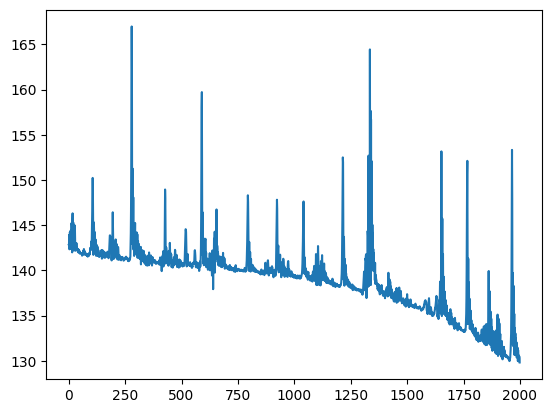

In [178]:
plt.plot(hist.history['loss'])

In [183]:
# def test_model(model, numSamples = 1000):
numSamples = 50

pi    = np.pi
X     = tf.cast(np.linspace(start=0, stop=3.5, num=numSamples), dtype='float32')
Y     = X + 0.3*(tf.math.sin(2*pi*X) + tf.sin(4*pi*X));
X     = tf.reshape(X, (numSamples, input_dim))
out   = model(X)
y_pred, log_sigma = tf.unstack(out)


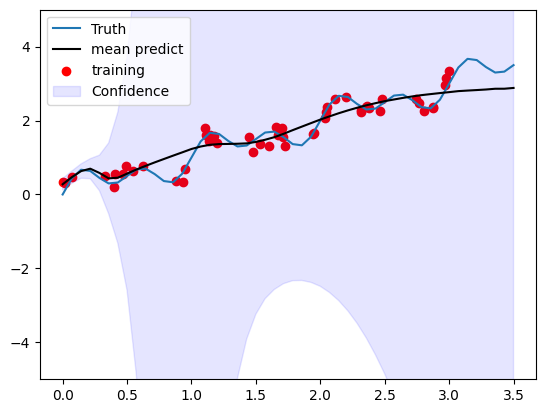

In [184]:
sig = tf.exp(log_sigma)
fig, ax = plt.subplots()
ax.plot(X,Y, label = 'Truth')
ax.plot(X, y_pred, c='k', label = 'mean predict')
ax.scatter(x_train, y_train, c='r', label = 'training')
ax.fill_between(tf.squeeze(X), tf.squeeze(y_pred-1*sig),
                tf.squeeze(y_pred+1*sig), color='b',
                alpha=.1, label = 'Confidence',
                interpolate=True)
ax.axes.set_ylim([-5,5])
ax.legend()


In [139]:
sig

<tf.Tensor: shape=(1000, 1), dtype=float32, numpy=
array([[6.84458241e-02],
       [6.53871223e-02],
       [6.28352687e-02],
       [6.06798306e-02],
       [5.88313229e-02],
       [5.72179109e-02],
       [5.57816811e-02],
       [5.44763058e-02],
       [5.32649457e-02],
       [5.21184243e-02],
       [5.10140359e-02],
       [4.99342605e-02],
       [4.88663353e-02],
       [4.78009693e-02],
       [4.67323996e-02],
       [4.56574075e-02],
       [4.45754007e-02],
       [4.34875339e-02],
       [4.23967615e-02],
       [4.13072444e-02],
       [4.02240828e-02],
       [3.91529500e-02],
       [3.80997807e-02],
       [3.70705128e-02],
       [3.60707343e-02],
       [3.51055078e-02],
       [3.41792032e-02],
       [3.32953744e-02],
       [3.24567631e-02],
       [3.16652134e-02],
       [3.09217032e-02],
       [3.02266050e-02],
       [2.95795109e-02],
       [2.89795399e-02],
       [2.84254551e-02],
       [2.79156640e-02],
       [2.74484195e-02],
       [2.70219836e-02],